In [309]:
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))

In [349]:
status = pd.read_json("./status.json")
status.insert(0, "Algorithm", status.index)
pandas_df_to_markdown_table(status)

Algorithm|Implemented|Status|Issues|Possible Solutions
---|---|---|---|---
CFR|✅|✅|None|N/A
DeepCFR|✅|❌|Does not converge|
ED|✅|❌|Does not converge|~~Parameter sweep from paper~~, contact lanctot
XFP|✅|✅|None|N/A
NFSP|✅|✅*|better than OS reported; OS inconsistent w/ Heinrich Silver|contact lanctot
RPG / RMPG / QPG|No|N/A|N/A|N/A
PSRO|No|N/A|N/A|N/A
RCFR|✅|✅*|Consistent w/ Waugh et. al; Not quite as good as OS reported |~~larger network~~, contact lanctot


In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [73]:
def load_batch(log_records, idx_offset=0):
    dat = pd.DataFrame()
    for path, label in log_records:
        d = pd.read_csv(path)
        d = d.set_index('iteration').rename(columns={'exploitability':label})
        dat = dat.join(d, how='outer')
    dat.index += idx_offset
    return dat

def log_interp(df, method="index"):
    df.index = df.index.map(np.log)
    df = df.apply(np.log)
    
    df = df.interpolate(method=method)
    
    df.index = df.index.map(np.exp)
    df = df.apply(np.exp)
    return df

# Figure 1
Convergence rates of XFP and ED algorithms on various partially-observable games in OpenSpiel. The units of the x-axis is iterations and the units of the y-axis is NashConv. Figure taken from [47]

### Notes:
- in ED paper: "We performed a sweep over the number of hidden layers (from 1 to 5), the number of hidden units (64, 128 or 256), the regularization weight (10^-7, 10^-6, 10^-5, 10^-4), and the initial learning rate (powers of 2). The plotted results show the best values from this sweep for each game."

[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Exploitability')]

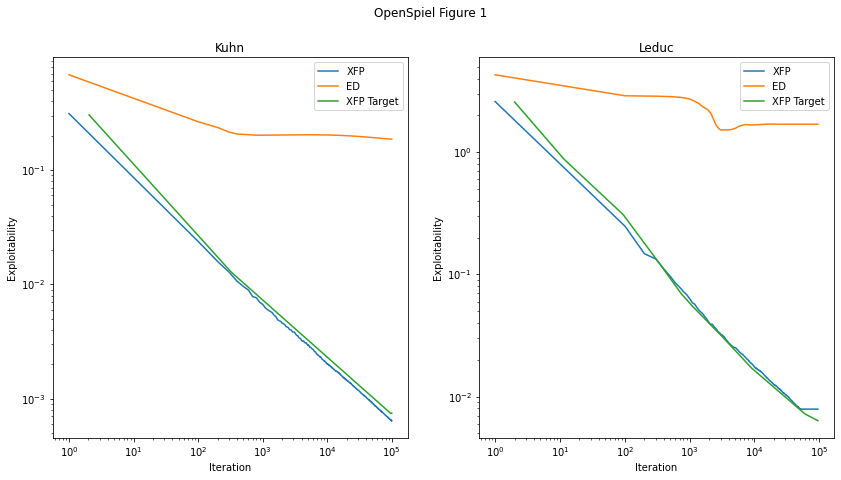

In [247]:
kuhn_logs = [#("./logs/cfr_kuhn_1.csv", "CFR"),
             ("./logs/xfp_kuhn_0.csv", "XFP"),
             ("./logs/exp_descent_kuhn_1.csv", "ED"),
             #("./target_results/fig1_cfr_kuhn.csv", "CFR Target"),
             ("./target_results/fig1_xfp_kuhn.csv", "XFP Target")
            ]

leduc_logs = [#("./logs/cfr_leduc_2.csv", "CFR"),
              ("./logs/xfp_leduc_1.csv", "XFP"),
              ("./logs/exp_descent_leduc_1.csv", "ED"),
              #("./target_results/fig1_cfr_leduc.csv", "CFR Target"),
              ("./target_results/fig1_xfp_leduc.csv", "XFP Target")
            ]

kuhn_dat = log_interp(load_batch(kuhn_logs, idx_offset=1))
leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))

# correct for exp = NashConv / 2
#kuhn_dat["CFR Target"] /= 2
kuhn_dat["XFP Target"] /= 2
#leduc_dat["CFR Target"] /= 2
leduc_dat["XFP Target"] /= 2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
fig.suptitle('OpenSpiel Figure 1')

ax = kuhn_dat.plot(title="Kuhn", logx=True, logy=True, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_xlim((1, 10e4))
#ax.set_ylim((10e-7, 1))

ax = leduc_dat.plot(title="Leduc", loglog=True, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_xlim((1, 10e4))
#ax.set_ylim((10e-4, 10))

# Figure 2
Convergence rate of RCFR in Leduc poker using a 2-layer network with 400 hidden units in each layer. The average policy is computed exactly (i.e. tabular), and regression targets are the
cumulative predicted regrets.

[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Exploitability')]

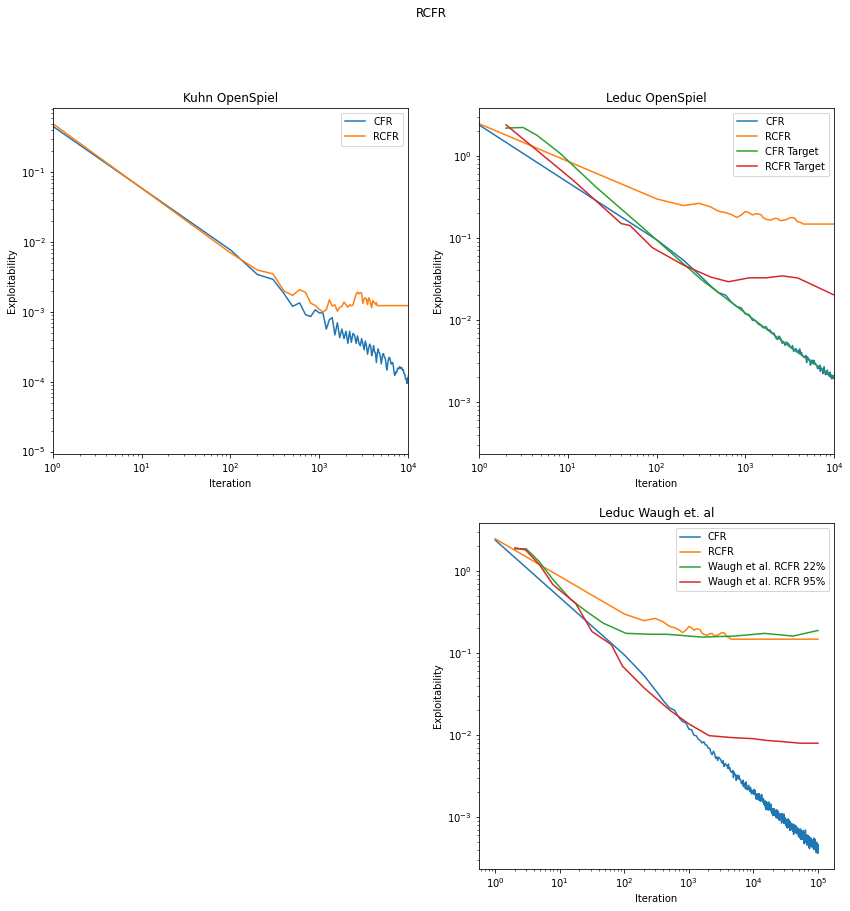

In [255]:
kuhn_logs = [("./logs/cfr_kuhn_1.csv", "CFR"),
             ("./logs/rcfr_kuhn_3.csv", "RCFR"),
            ]

leduc_logs = [("./logs/cfr_leduc_2.csv", "CFR"),
              ("./logs/rcfr_leduc_1.csv", "RCFR"),
              ("./target_results/fig2_cfr_leduc.csv", "CFR Target"),
              ("./target_results/fig2_rcfr_leduc.csv", "RCFR Target"),
              ("./target_results/rcfr_waugh_leduc_22.csv", "Waugh et al. RCFR 22%"),
              ("./target_results/rcfr_waugh_leduc_95.csv", "Waugh et al. RCFR 95%")
            ]

kuhn_dat = log_interp(load_batch(kuhn_logs, idx_offset=1))
leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))

# milli blind conversion, additional 1/10 scale correct for error in plot extraction
leduc_dat["Waugh et al. RCFR 22%"] *= .0001
leduc_dat["Waugh et al. RCFR 95%"] *= .0001

# nash conv -> exp
leduc_dat["CFR Target"] /= 2
leduc_dat["RCFR Target"] /= 2

log_log = True
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
fig.suptitle('RCFR')
fig.delaxes(axes[1,0])

ax = kuhn_dat.plot(title="Kuhn OpenSpiel", logy=log_log, logx=log_log, ax=axes[0,0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_xlim((1, 10e3))

os_targets = ["CFR", "RCFR", "CFR Target", "RCFR Target"]
ax = leduc_dat[os_targets].plot(title="Leduc OpenSpiel", logy=log_log, logx=log_log, ax=axes[0,1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_xlim((1, 10e3))
#ax.set_ylim((10e-4, 10))

os_targets = ["CFR", "RCFR", "Waugh et al. RCFR 22%", "Waugh et al. RCFR 95%"]
ax = leduc_dat[os_targets].plot(title="Leduc Waugh et. al", logy=log_log, logx=log_log, ax=axes[1,1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
#ax.set_xlim((1, 10e3))

# Figure 3
Convergence rates of NFSP and various (regret-based) policy gradient algorithms in 2-player Leduc poker. Each line is an __average over the top five seeds and hyperparemeter settings for each algorithm__. The lowest (around 0.2) exploitability value reached by any individual run is depicted by a dashed line.

[Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Exploitability')]

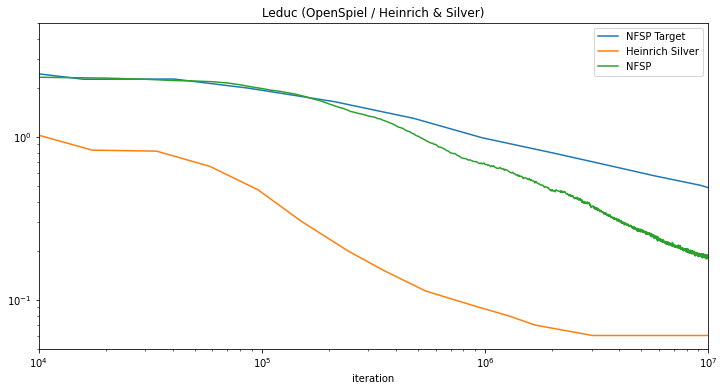

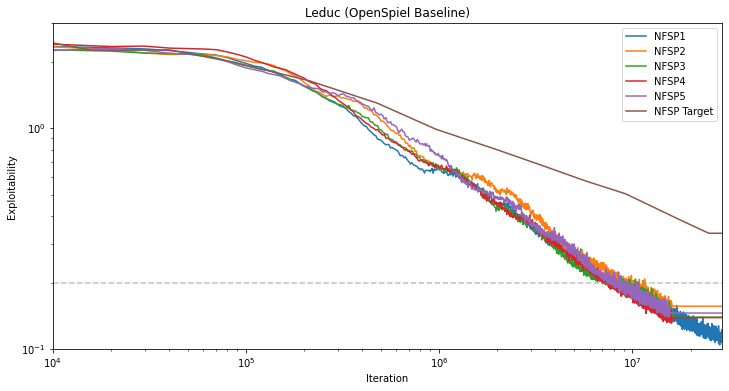

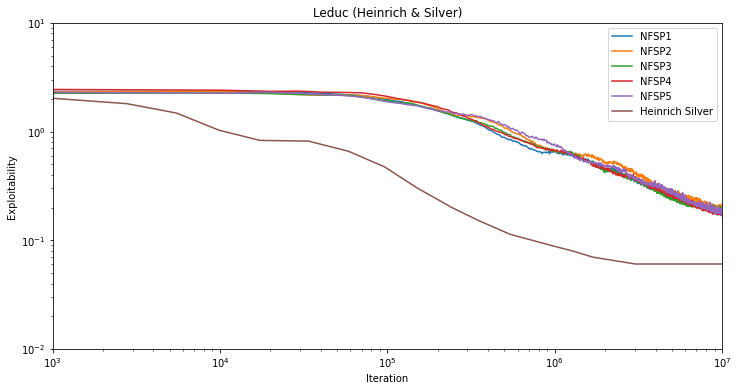

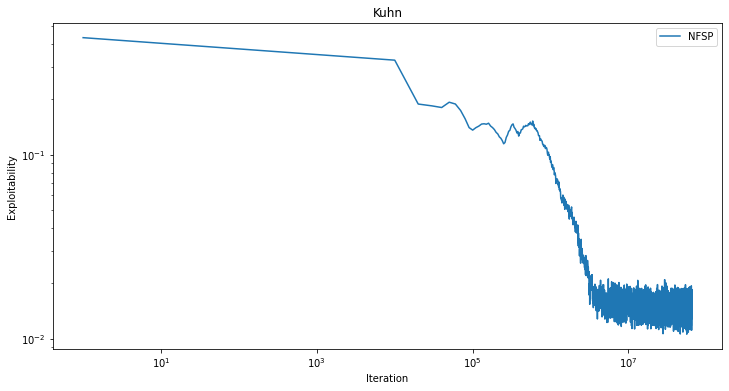

In [280]:
kuhn_logs = [("./logs/nfsp_kuhn_2.csv", "NFSP")
            ]

leduc_logs = [("./logs/nfsp_leduc_1.csv", "NFSP1"),
              ("./logs/nfsp_leduc_2.csv", "NFSP2"),
              ("./logs/nfsp_leduc_3.csv", "NFSP3"),
              ("./logs/nfsp_leduc_4.csv", "NFSP4"),
              ("./logs/nfsp_leduc_5.csv", "NFSP5"),
              ("target_results/fig3_nfsp_leduc.csv", "NFSP Target"),
              ("target_results/nfsp_heinrich_silver_leduc_128.csv", "Heinrich Silver")
            ]

kuhn_dat = log_interp(load_batch(kuhn_logs, idx_offset=1)).dropna()
leduc_dat = log_interp(load_batch(leduc_logs, idx_offset=1))

leduc_mean = pd.DataFrame(leduc_dat[["NFSP1","NFSP2","NFSP3","NFSP4","NFSP5",]].mean(1), columns=["NFSP"])
avg_leduc = leduc_dat[["NFSP Target", "Heinrich Silver"]].join(leduc_mean)
ax = avg_leduc.plot(title="Leduc (OpenSpiel / Heinrich & Silver)", loglog=True, figsize=(12,6))
ax.set_ylim((.05, 5))
ax.set_xlim((1e4, 1e7))

ax = leduc_dat.drop("Heinrich Silver", axis=1).plot(title="Leduc (OpenSpiel Baseline)", loglog=True, figsize=(12,6))
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.axhline(y=0.2, color='gray', alpha=.5, linestyle='--')
ax.set_ylim((.1))
ax.set_xlim((1e4, max(leduc_dat.index)))

ax = leduc_dat.drop("NFSP Target", axis=1).plot(title="Leduc (Heinrich & Silver)", loglog=True, figsize=(12,6))
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_ylim((.01, 10))
ax.set_xlim((1e3, 1e7))

ax = kuhn_dat.plot(title="Kuhn", loglog=True, figsize=(12,6))
ax.set(xlabel="Iteration", ylabel="Exploitability")

# DeepCFR

Text(0.5, 0.98, 'DeepCFR')

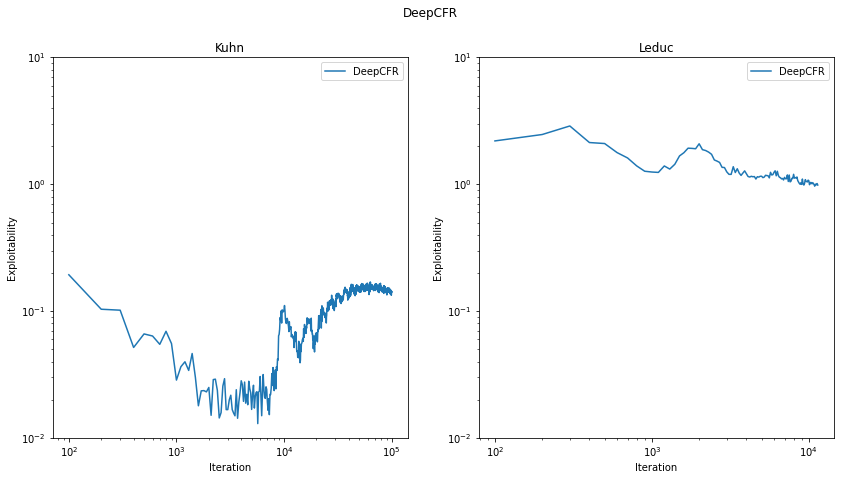

In [236]:
kuhn_logs = [("./logs/deep_cfr_kuhn_0.csv", "DeepCFR")
            ]

leduc_logs = [("./logs/deep_cfr_leduc_4.csv", "DeepCFR")
            ]

kuhn_dat = load_batch(kuhn_logs)
leduc_dat = load_batch(leduc_logs)

log_log = True
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7))
ax = kuhn_dat.plot(title="Kuhn", logy=log_log, logx=log_log, ax=axes[0])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_ylim((.01, 10))
ax = leduc_dat.plot(title="Leduc", logy=log_log, logx=log_log, ax=axes[1])
ax.set(xlabel="Iteration", ylabel="Exploitability")
ax.set_ylim((.01, 10))
fig.suptitle('DeepCFR')

# PSRO